In [11]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz 
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, CategoricalNB

# Pre-Modeling Analysis

In [4]:

def y_bins(y_cols, cuts):

    labels = [f"< ${c}M" for c in cuts[1:]]
    y = pd.cut(y_cols['Global_Sales'], bins=cuts, labels=labels)

    # Plot histogram
    sns.histplot(data=y, kde=True)
    plt.title('Distribution of Global Sales')
    plt.show()

    # create bins to encode sales columns
    y_bins = {}
    for y in y_cols:
        y_bins[y] = pd.Series(pd.cut(y_cols[y], bins=cuts, labels=labels))
    return pd.DataFrame(y_bins)


In [3]:

# encoded data
df = pd.read_csv("data\\fullyEncoded.csv", header=0)
df.head()


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,10919.0,26.0,2006.0,10.0,361.0,41.36,28.96,3.77,8.45,82.53,76.000000,51.000000,77.000000,322.000000,1008.000000,1.000000
1,9265.0,11.0,1985.0,4.0,361.0,29.08,3.58,6.81,0.77,40.24,68.997119,26.440992,74.727254,163.008846,835.050081,3.558616
2,5534.0,26.0,2008.0,6.0,361.0,15.68,12.76,3.79,3.29,35.52,82.000000,73.000000,80.000000,709.000000,1008.000000,1.000000
3,10921.0,26.0,2009.0,10.0,361.0,15.61,10.93,3.28,2.95,32.77,80.000000,73.000000,77.000000,192.000000,1008.000000,1.000000
4,7294.0,5.0,1996.0,7.0,361.0,11.27,8.89,10.22,1.00,31.37,68.997119,26.440992,74.727254,163.008846,835.050081,3.558616


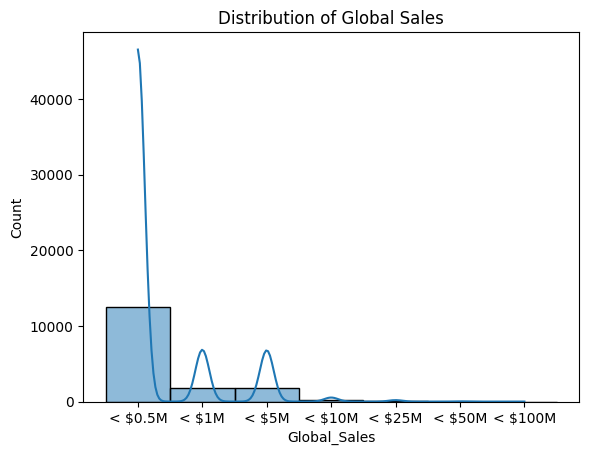

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
10026,< $0.5M,< $0.5M,< $0M,< $0M,< $0.5M
1520,< $5M,< $0.5M,< $0.5M,< $0.5M,< $5M
16403,< $0M,< $0.5M,< $0M,< $0M,< $0.5M
15649,< $0M,< $0.5M,< $0M,< $0M,< $0.5M
16230,< $0M,< $0.5M,< $0M,< $0M,< $0.5M


In [5]:

# split into feature columns and sales columns (y vars.)
sales = []
feats = []
for name in list(df.columns):
    if "Sales" in name:
        sales.append(name)
    else:
        feats.append(name)

y_cols = df[sales]
x_cols = df[feats]

cuts = [float('-inf'), 0, 0.5, 1, 5, 10, 25, 50, 100]
# cuts = [0, 1, 5, 10, 25, 50, 100]

y_col_bins = y_bins(y_cols, cuts)
x_train, x_test, y_train, y_test = train_test_split(x_cols, y_col_bins, test_size=0.2)

y_train.head()


In [9]:

for region in y_cols:
    no_sales = len(df[df[region]==0])
    r = region.split("_")[0]
    print(f'[{r}] data is {no_sales/len(df):.2%} items with no recorded sales.\n')

y_cols.describe()

[NA] data is 27.08% items with no recorded sales.

[EU] data is 35.13% items with no recorded sales.

[JP] data is 62.57% items with no recorded sales.

[Other] data is 39.42% items with no recorded sales.

[Global] data is 0.00% items with no recorded sales.



,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16416.000000,16416.000000,16416.000000,16416.000000,16416.000000
mean,0.264129,0.146034,0.078623,0.047670,0.536708
std,0.819028,0.507134,0.311348,0.188156,1.559885
min,0.000000,0.000000,0.000000,0.000000,0.010000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.170000
75%,0.240000,0.110000,0.040000,0.030000,0.470000
max,41.360000,28.960000,10.220000,10.570000,82.530000


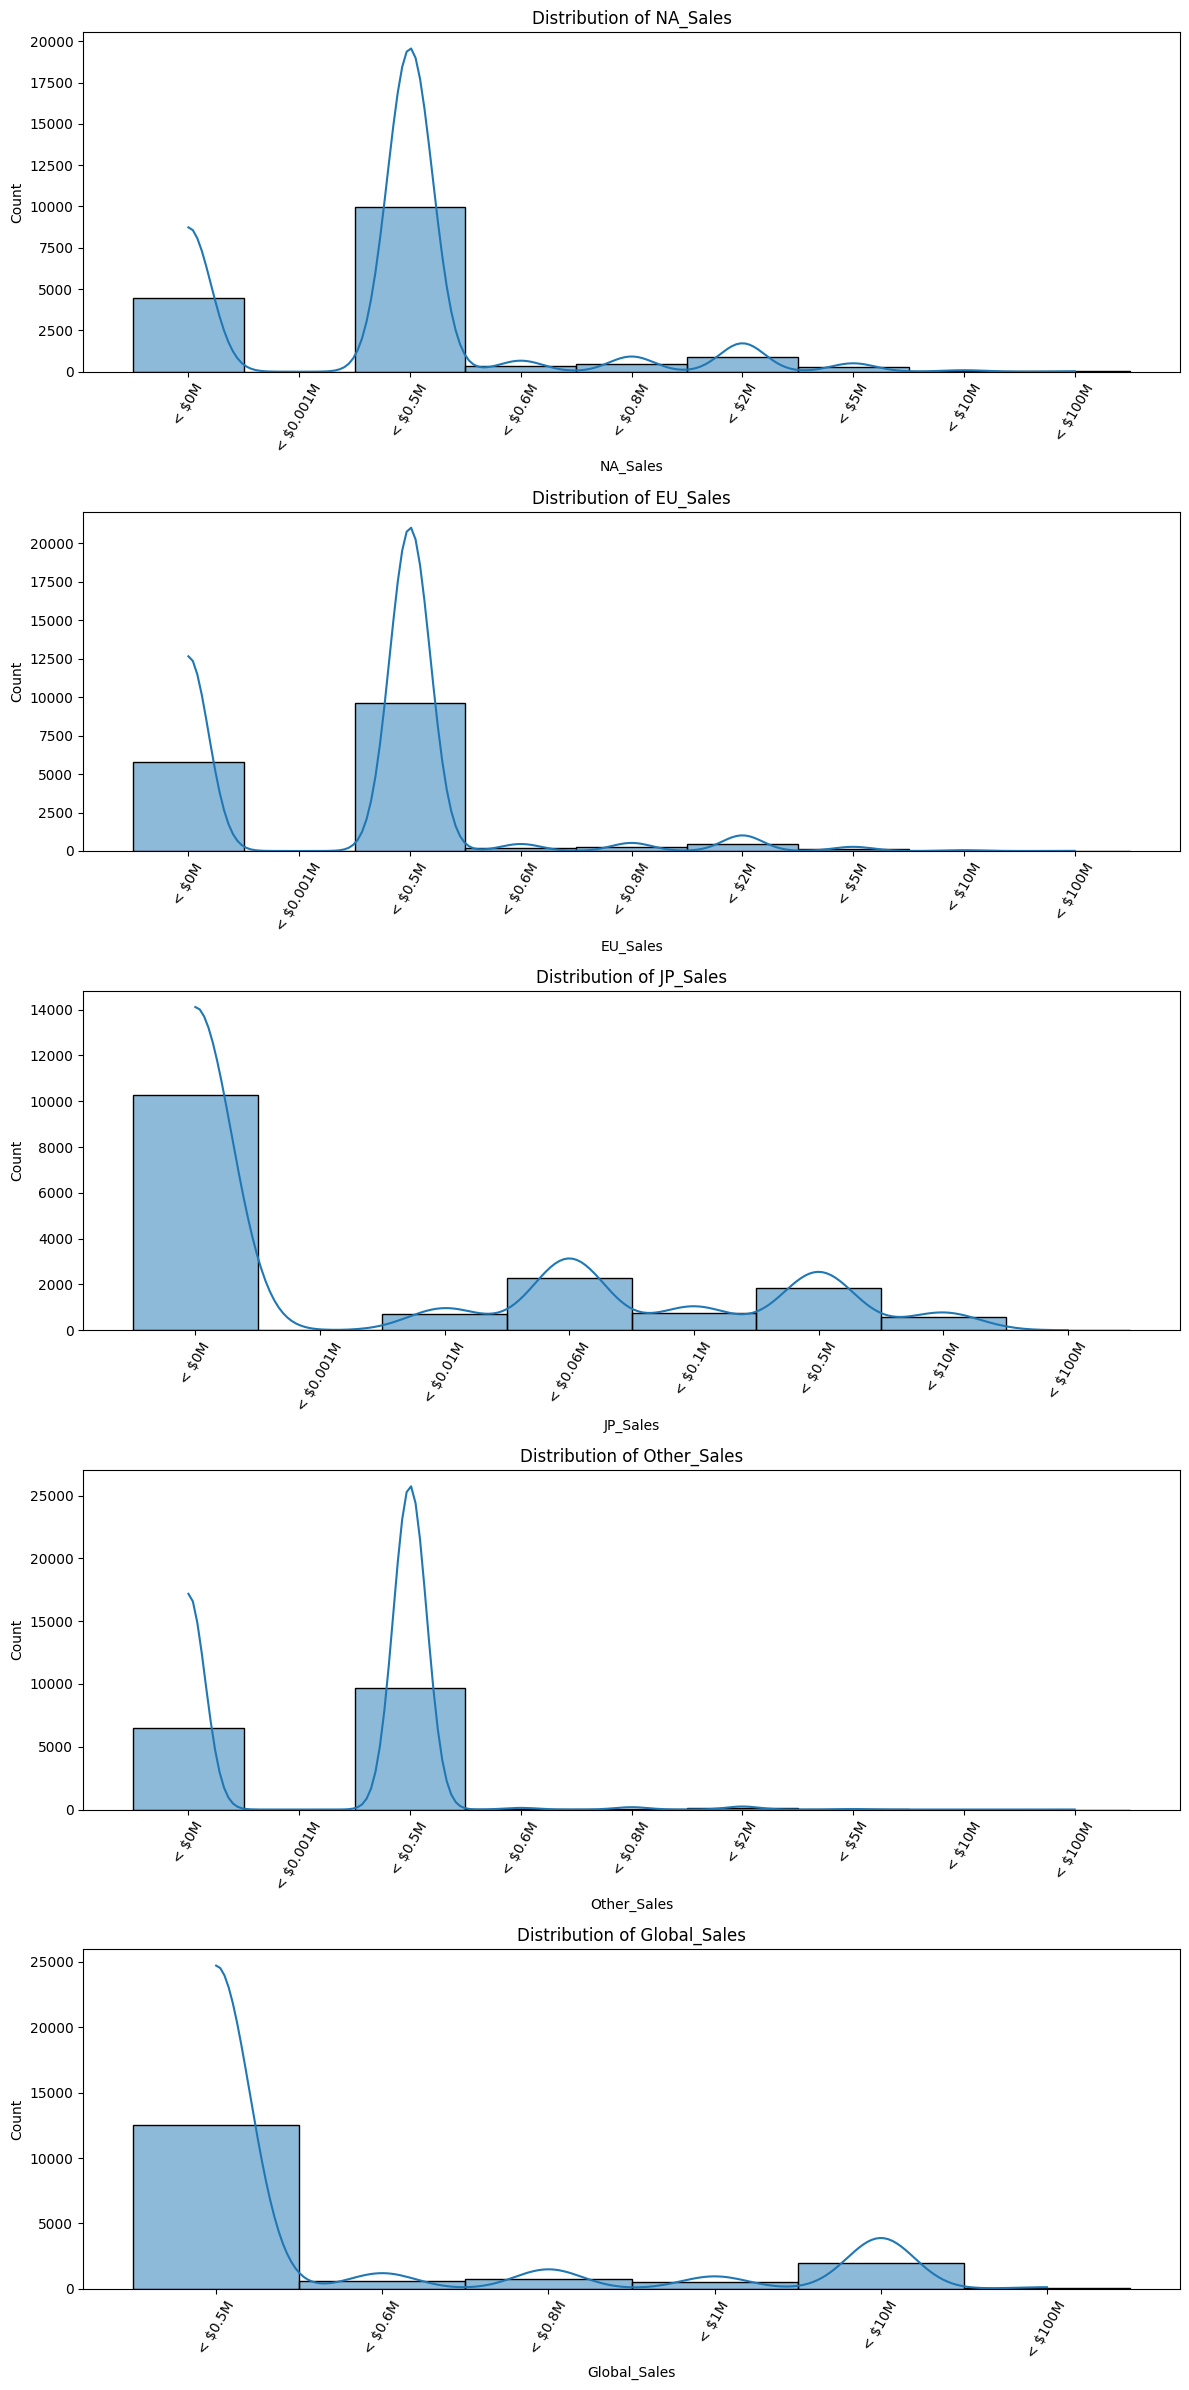

In [10]:
# split into bins
cuts = {
    'NA_Sales':     [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5, 10, 100],
    'EU_Sales':     [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5, 10, 100],
    'JP_Sales':     [float('-inf'), 0, 0.001, 0.01, 0.06, 0.1, 0.5, 10, 100],
    'Other_Sales':  [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5, 10, 100],
    'Global_Sales': [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 1, 10, 100]
}

y_bins = {}

# Plot the top 3 principal components with their corresponding feature names
fig, axs = plt.subplots(5, 1, figsize=(12,24))
for i in range(5):
    y = y_cols.columns[i]
    bin_labels = [f"< ${c}M" for c in cuts[y]][1:]
    y_var = pd.Series(pd.cut(y_cols[y], bins = cuts[y], labels = bin_labels))
    y_bins[y] = y_var
    
    sns.histplot(data = y_var, kde = True, ax = axs[i])
    axs[i].set_title(f'Distribution of {y}')
    plt.setp(axs[i].get_xticklabels(), rotation=60)
    plt.tight_layout()

y_col_bins = pd.DataFrame(y_bins) 

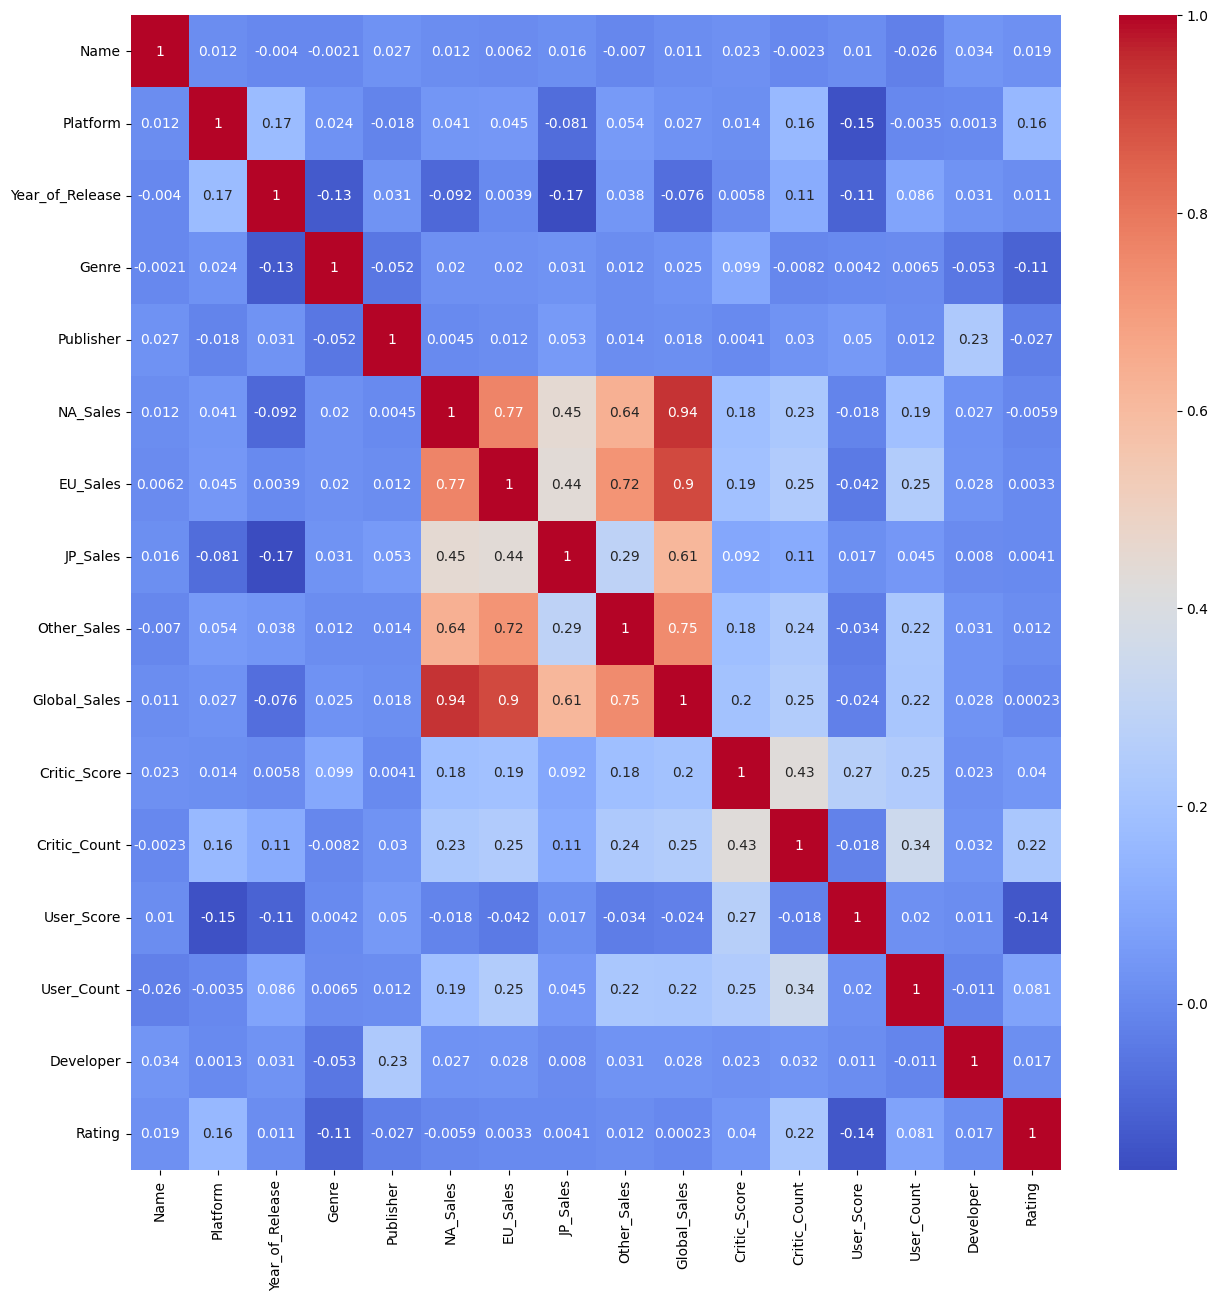

In [16]:

# cmap = sns.cubehelix_palette(start=0.5, rot=-0.3, as_cmap=True)
cmap='coolwarm'
corrmat = df.corr()
top_corr_features = corrmat.index

#plot heat map
plt.figure(figsize=(15,15))
g=sns.heatmap(df[top_corr_features].corr(),
              annot=True,
              cmap=cmap) 


# PCA

In [20]:

# Fit PCA model with x features
pca = PCA()
pca.fit(x_cols)
# get principal components
X_pca = pca.transform(x_cols)

# Get the explained variance of PC and sort by weight
explained_var = pca.explained_variance_ratio_
importance = list(zip(x_cols.columns, explained_var))
importance.sort(key=lambda x: x[1], reverse=True)
print('Feature importance by explained variance:\n')
for i, (feat, var) in enumerate(importance):
    print(f'{i+1}. {feat}: {var:.4f}')


Feature importance by explained variance:

1. Name: 0.9711
2. Platform: 0.0134
3. Year_of_Release: 0.0129
4. Genre: 0.0026
5. Publisher: 0.0000
6. Critic_Score: 0.0000
7. Critic_Count: 0.0000
8. User_Score: 0.0000
9. User_Count: 0.0000
10. Developer: 0.0000
11. Rating: 0.0000


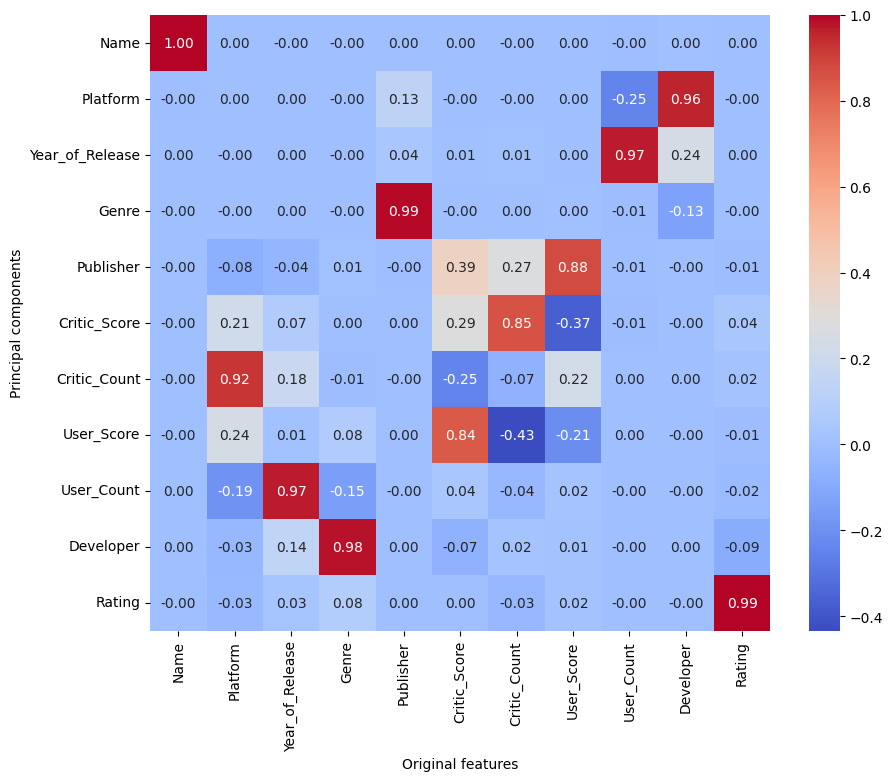

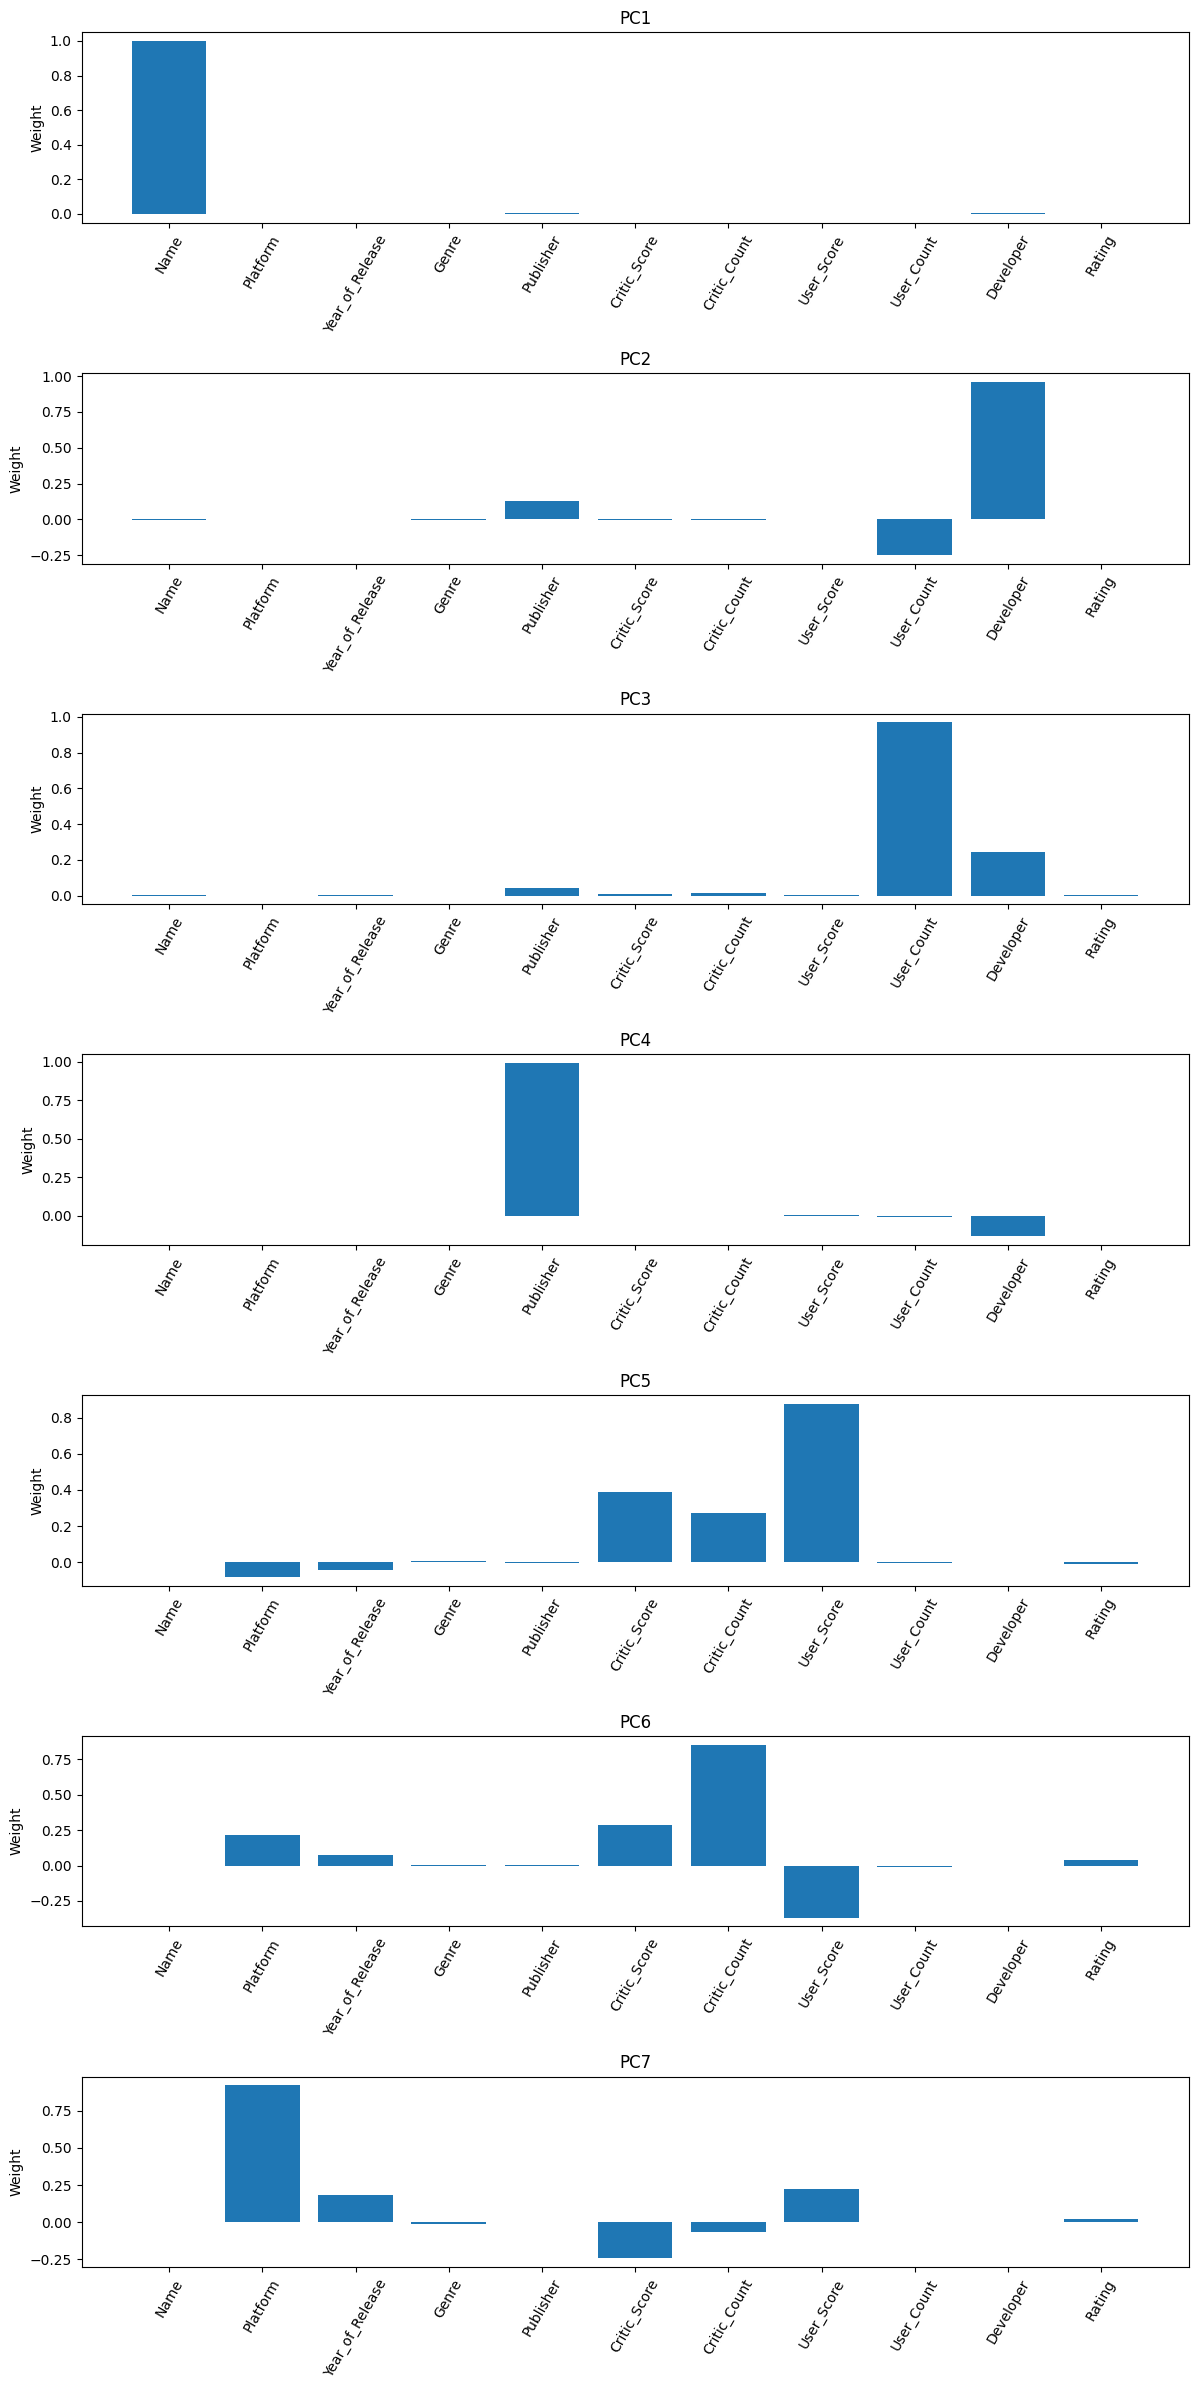

In [22]:
feats = list(zip(*importance))[0]

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pca.components_, cmap=cmap,
            annot=True, fmt='.2f', 
            xticklabels=x_cols.columns,
            yticklabels=feats,
            vmax=1.0)
ax.set_xlabel('Original features')
ax.set_ylabel('Principal components')

# Get the names of the input features
feature_names = list(x_cols.columns)
n_plots = 7

# Show size of each PC vector's eigenvalues/weights
fig, axs = plt.subplots(n_plots, 1, figsize=(12, 24))
for i in range(n_plots):
    axs[i].bar(feature_names, pca.components_[i])
    axs[i].set_title(f'PC{i+1}')
    axs[i].set_ylabel('Weight')
    plt.setp(axs[i].get_xticklabels(), rotation=60)
    
plt.tight_layout()

plt.show()

# Decision Trees

## Decision Tree Classifier + Grid Search

In [26]:

# function to update max_leaf_nodes for DT classifier
clf = lambda x: DecisionTreeClassifier(max_leaf_nodes=x)

def build_decision_tree(max_nodes, y_test_cat, y_train_cat, view_mode=False):
    # build classifier with specified max leaf nodes
    classifier = clf(max_nodes)
    # fit classifier to training data
    classifier.fit(x_train, np.ravel(y_train_cat))
    # export tree data with feature and class labels to graph visualizer
    dot_data = tree.export_graphviz(classifier, 
                                    out_file=None, 
                                    feature_names=feats, 
                                    class_names=labels,
                                    impurity=False, filled=True, rounded=True)  
    
    # create the DT graph and render as a png
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render('decision_tree',view=view_mode)
    
    # calculate classifier score
    score = classifier.score(x_test, y_test_cat)
    y_pred = classifier.predict(x_test)
    print(f'Score: {score}\n')
    
    return score, y_pred

def grid_search(y_train):
    # initialze DT classifier
    max_nodes = None
    classifier = clf(max_nodes)
    
    # set max node range and suppress warning for small bins
    warnings.filterwarnings("ignore", category=UserWarning)
    params = {'max_leaf_nodes': list(range(3, 100))}
    
    # use grid search to get max leaf nodes hyperparameter
    grid_search = GridSearchCV(classifier, params)
    grid_search.fit(x_train, y_train)

    # update max node value
    max_nodes = grid_search.best_estimator_.get_params()["max_leaf_nodes"]
    print(f'Max. leaf nodes from grid search: {max_nodes}')
    
    return max_nodes


In [28]:

y_preds = {}

for category in y_test:
    test, train = y_test[category], y_train[category]
    cat_title = ' '.join(category.split('_'))
    print(f'{cat_title} Classification:')
    
    max_nodes = grid_search(train)
    score, prediction = build_decision_tree(max_nodes, test, train)
    y_preds[category] = (score, prediction)
      

NA Sales Classification:
Max. leaf nodes from grid search: 65
Score: 0.7667478684531059

EU Sales Classification:
Max. leaf nodes from grid search: 98
Score: 0.7527405602923264

JP Sales Classification:
Max. leaf nodes from grid search: 95
Score: 0.8109013398294762

Other Sales Classification:
Max. leaf nodes from grid search: 67
Score: 0.7801461632155907

Global Sales Classification:
Max. leaf nodes from grid search: 99
Score: 0.7874543239951279



### Bins from Bayesian model

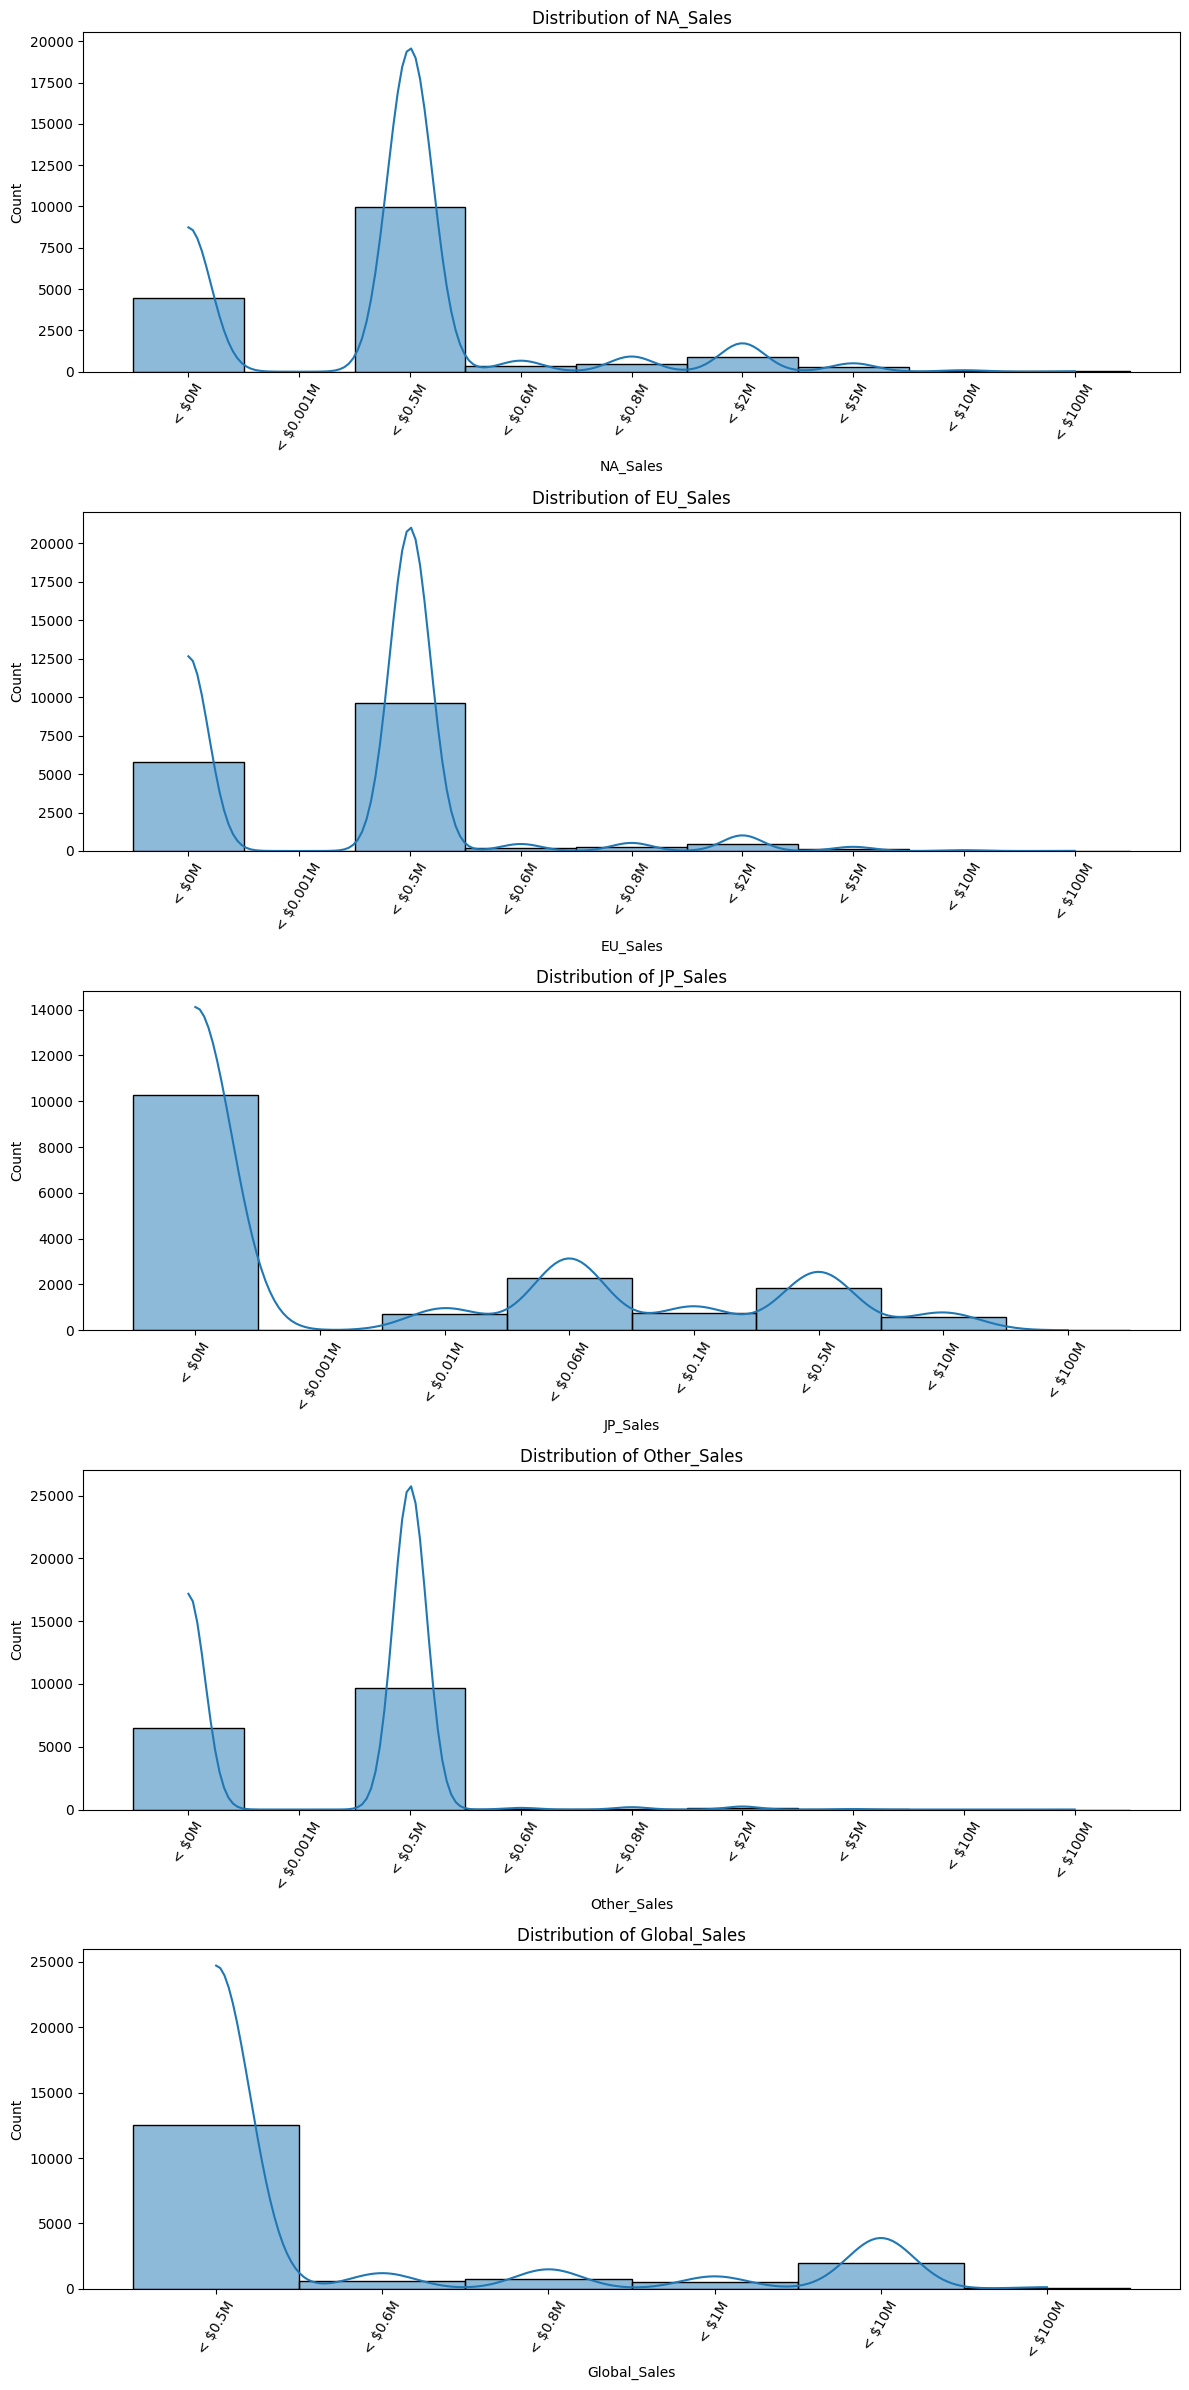

In [29]:

cuts = {
    'NA_Sales':     [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5, 10, 100],
    'EU_Sales':     [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5, 10, 100],
    'JP_Sales':     [float('-inf'), 0, 0.001, 0.01, 0.06, 0.1, 0.5, 10, 100],
    'Other_Sales':  [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5, 10, 100],
    'Global_Sales': [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 1, 10, 100]
}
y_bins = {}

# Plot the distributions for each region
fig, axs = plt.subplots(5, 1, figsize=(12,24))
for i in range(5):
    y = y_cols.columns[i]
    bin_labels = [f"< ${c}M" for c in cuts[y]][1:]
    y_var = pd.Series(pd.cut(y_cols[y], bins=cuts[y], labels=bin_labels))
    y_bins[y] = y_var
    
    sns.histplot(data=y_var, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {y}')
    plt.setp(axs[i].get_xticklabels(), rotation=60)
    plt.tight_layout()

y_col_bins = pd.DataFrame(y_bins) 


In [30]:

x_train, x_test, y_train, y_test = train_test_split(x_cols, y_col_bins, test_size=0.2)


In [31]:

y_preds = {}
for category in y_test:
    test, train = y_test[category], y_train[category]
    cat_title = ' '.join(category.split('_'))
    print(f'{cat_title} Classification:')
    
    max_nodes = grid_search(train)
    score, prediction = build_decision_tree(max_nodes, test, train)
    y_preds[category] = (score, prediction)
    

NA Sales Classification:
Max. leaf nodes from grid search: 97
Score: 0.7743605359317906

EU Sales Classification:
Max. leaf nodes from grid search: 76
Score: 0.7448233861144945

JP Sales Classification:
Max. leaf nodes from grid search: 97
Score: 0.6982338611449452

Other Sales Classification:
Max. leaf nodes from grid search: 72
Score: 0.7700974421437271

Global Sales Classification:
Max. leaf nodes from grid search: 55
Score: 0.807551766138855



## Random Forest DT

In [32]:

max_nodes = 50
classifier = RandomForestClassifier(n_estimators=50, max_leaf_nodes=max_nodes)
classifier.fit(x_train, y_train)

RF_pred = classifier.predict(x_test)
score = classifier.score(x_test, y_test)

print(f"Score: {score}")


ValueError: multiclass-multioutput is not supported

# Naive Bayes

# Logistic Regression

# Linear Regression